# Imports

In [1]:
# GENERAL
import numpy as np
import scipy.stats as stats

# if one want interactive plotting zoom/tools :
%matplotlib notebook 
# inline non-interactive plots:
# %matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [7.,5.] #set size of plots
import matplotlib as mpl


# LISA
from LISAhdf5 import LISAhdf5,ParsUnits
import tdi
import LISAParameters as LP

# PERSO
import Tools
import Tools.utils as utils
import Tools.normalized_L1_minimization as normL1min
import Tools.reweighting as weight
import Tools.blocktree as blocktree


# Reference Signal

In [2]:
# folder that contains the data
myfolder = "./LDC_1-3/" #
# noisy input file name
myfile_REF = "LDC1-3_VGB_v2.hdf5" #"monoVGB_f2_beta0_FD_noiseless.hdf5" #"GB_mono_source_FD_noiseless.hdf5" #"LDC1-3_VGB_v2.hdf5" # #"LDC1-3_VGB_v2_FD_noiseless.hdf5" #_FD_noiseless #"GB_mono_source_FD_noiseless.hdf5"
#non-noisy input file name
myfile_NonNoisy = "LDC1-3_VGB_v2_FD_noiseless.hdf5"


In [3]:
#reference data (without noise)
FD5 =  LISAhdf5(myfolder+myfile_NonNoisy)
GWs = FD5.getSourcesName()
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))


tm = td[:, 0]
Npts = len(tm)
Xt0 = td[:, 1]
Yt0 = td[:, 2]
Zt0 = td[:, 3]

At0 = (Zt0 - Xt0)/np.sqrt(2.0)
Et0 = (Zt0 - 2.0*Yt0 + Xt0)/np.sqrt(6.0)
Adf0 = np.fft.rfft(At0) * del_t
Edf0 = np.fft.rfft(Et0) * del_t
freqD = np.fft.rfftfreq(len(tm), del_t)
Nf = freqD.shape[0]

yt0_noNoise = np.concatenate((At0.reshape((Npts,1)),Et0.reshape((Npts,1))), axis=1)
yf0_noNoise = np.concatenate((Adf0.reshape((Nf,1)),Edf0.reshape((Nf,1))), axis=1)


/local/home/ablelly/.local/lib/python3.6/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/local/home/ablelly/.local/lib/python3.6/site-packages/LISAhdf5.py:741: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)


In [4]:
#Noisy data
FD5 =  LISAhdf5(myfolder+myfile_REF)
GWs = FD5.getSourcesName()
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))


tm = td[:, 0]
Npts = len(tm)
Xt0 = td[:, 1]
Yt0 = td[:, 2]
Zt0 = td[:, 3]

At0 = (Zt0 - Xt0)/np.sqrt(2.0)
Et0 = (Zt0 - 2.0*Yt0 + Xt0)/np.sqrt(6.0)
Adf0 = np.fft.rfft(At0) * del_t
Edf0 = np.fft.rfft(Et0) * del_t
freqD = np.fft.rfftfreq(len(tm), del_t)
Nf = freqD.shape[0]

yt0 = np.concatenate((At0.reshape((Npts,1)),Et0.reshape((Npts,1))), axis=1)
yf0 = np.concatenate((Adf0.reshape((Nf,1)),Edf0.reshape((Nf,1))), axis=1)



# LISA Gaussian Noise

In [5]:
noiseModel = 'SciRDv1'
PSD_A = Npts*np.sqrt(del_t)*tdi.noisepsd_AE(freqD, model=noiseModel, includewd=None) #del_t*
PSD_E = Npts*np.sqrt(del_t)*tdi.noisepsd_AE(freqD, model=noiseModel, includewd=None)
PSD_A[0] = 100.*PSD_A[1] #otherwise, Nan
PSD_E[0] = 100.*PSD_E[1] #otherwise, Nan

Nf = len(freqD)

N_A = np.sqrt(PSD_A)*(np.random.randn(Nf) + 1.j*np.random.randn(Nf))
N_E = np.sqrt(PSD_E)*(np.random.randn(Nf) + 1.j*np.random.randn(Nf))

/local/home/ablelly/.local/lib/python3.6/site-packages/tdi.py:647: RuntimeWarning: divide by zero encountered in true_divide
  Sa_a = LP.Sa_a[model] *(1.0 +(0.4e-3/frq)**2)*(1.0+(frq/8e-3)**4)
/local/home/ablelly/.local/lib/python3.6/site-packages/tdi.py:649: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a*(2.*np.pi*frq)**(-4.)
/local/home/ablelly/.local/lib/python3.6/site-packages/tdi.py:651: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d*(2.0*np.pi*frq/LC.clight)**2
/local/home/ablelly/.local/lib/python3.6/site-packages/tdi.py:656: RuntimeWarning: divide by zero encountered in true_divide
  Soms_d = LP.Soms_d[model] * (1. + (2.e-3/f)**4)
/local/home/ablelly/.local/lib/python3.6/site-packages/tdi.py:658: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d*(2.0*np.pi*frq/LC.clight)**2


# Normalize Noisy data

In [7]:

A = 1. # amplitude multiplier
do_sig_corr = 1 #only for LDC data: PSD correction
do_add_noise = 0 #if input is non-noisy data, will add gaussian noise


if do_add_noise:
    Adf = A*Adf0 + N_A
    Edf = A*Edf0 + N_E
else:
    Adf = A*Adf0
    Edf = A*Edf0

yAf = Adf 
yEf = Edf 

    
y_f = np.concatenate((yAf.reshape((Nf,1)),yEf.reshape((Nf,1))),axis=1)

yAt = np.fft.irfft(yAf/del_t, Npts)
yEt = np.fft.irfft(yEf/del_t, Npts)
y_t = np.concatenate((yAt.reshape((Npts,1)),yEt.reshape((Npts,1))),axis=1)



if do_sig_corr: 
    data_sig = np.load('stdDev_polApprox_order4_allCoeffs.npz')
    mycoeffs = data_sig['coeffs']
    poly_sig = np.poly1d(mycoeffs)
# normalization :
    sig = poly_sig(freqD)
    yAf = yAf / (np.sqrt(PSD_A)*sig)
    yEf = yEf / (np.sqrt(PSD_E)*sig)
else:
    yAf = yAf / np.sqrt(PSD_A)
    yEf = yEf / np.sqrt(PSD_E)

y_f = np.concatenate((yAf.reshape((Nf,1)),yEf.reshape((Nf,1))),axis=1)

yAt = np.fft.irfft(yAf/del_t, Npts)
yEt = np.fft.irfft(yEf/del_t, Npts)
y_t = np.concatenate((yAt.reshape((Npts,1)),yEt.reshape((Npts,1))),axis=1)
    


# Block Decomposition

In [8]:
do_blockTree = 1
p_tree = 0.99999 # rho =1. - p_tree
minBlockSize = 10
# parameters for a law of standard chi^2_4
myfactor = 4 
myscale = 1. 


if do_blockTree:
    if do_sig_corr: #correction only reasonnable for frequencies f<0.027Hz
        ind = (freqD<0.027) 
    else:
        ind = (freqD>=0.)
        
    nonzero_ind = np.where(ind)[0]
    print('max index : ',nonzero_ind[-1])
    y_tree = 0.*np.copy(y_f)
    y_tree[ind,:] = y_f[ind,:]
    
    # initialize tree
    mytree_init = blocktree.makeTree_BottomUp_init(minBlockSize,Nf,y_tree,p_tree, factor=myfactor, scale=myscale)
    
    tree_unif = np.copy(mytree_init) # tree made of uniform blocks
    
    # compute blockTree
    mytree = blocktree.makeTree_BottomUp(y_tree, mytree_init, p_tree, minBlockSize, Rcomp=5., factor=myfactor, scale=myscale)
    
    
    id_blocks = mytree[:,:3]
    
    # get list of active frequencies:
    active_index = np.full(freqD.shape, False)
    for i in range(mytree.shape[0]):
        if mytree[i,-2]:
            active_index[mytree[i,0]:mytree[i,1]+1] = np.full(mytree[i,2],True)
    
else:
    id_blocks = utils.create_regular_blocks(minBlockSize,Nf)

max index :  1698693


# L1 Minimization - Standard Resolution

In [9]:
# gaussian Noise
p_l1 = 0.99999 # acceptation rate. (rejection rate rho = 1-p_l1)
x0 = utils.find_threshold_chi2(4,p_l1) 
sigma_norm = 1. 
epsilon_gamma = 0.1*sigma_norm  #convervence parameter for reweighted L1 minimization
coeff_weights = 3. #coefficient for reweighting


#solution initialization
x_k = 0.*y_f 
x_kt = 0.*y_t

Lmax = 15 # max number of reweighting iterations

# set initial threshold
gamma_0 = np.sqrt(x0)*np.ones(freqD.shape)
gamma_n = gamma_0


### REWEIGHTED L1 minimization
l = 0
delta_gamma = 1.

while ((l < Lmax) and delta_gamma > epsilon_gamma):
    print('+++++ ITER ',l)
    # compute current solution
    x_k = normL1min.prox_f(y_f, gamma_n,alpha=1.)
    
    # compute new weights
    gamma_nm1 = gamma_n

    print('Reweighting')
    gamma_n = weight.compute_weights(x_k, gamma_0,coeff=coeff_weights)
    
    delta_gamma = np.amax(np.abs(gamma_n-gamma_nm1))
    l+=1
    

if do_sig_corr:
    Adf_sparse = np.sqrt(PSD_A)*sig*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*sig*x_k[:,1]
else:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]


At_sparse = np.fft.irfft(Adf_sparse / del_t, Npts)
Et_sparse = np.fft.irfft(Edf_sparse / del_t, Npts)
yt = np.concatenate((At_sparse.reshape((Npts,1)),Et_sparse.reshape((Npts,1))),axis=1)
print('END')

print('NMSE = ', utils.compute_logError(A*yt0_noNoise,yt))

+++++ ITER  0
Reweighting
+++++ ITER  1
Reweighting
+++++ ITER  2
Reweighting
+++++ ITER  3
Reweighting
+++++ ITER  4
Reweighting
+++++ ITER  5
Reweighting
+++++ ITER  6
Reweighting
+++++ ITER  7
Reweighting
+++++ ITER  8
Reweighting
+++++ ITER  9
Reweighting
END
NMSE =  -4.861628770387426


# BlockTree + Unstructured sparsity

In [10]:
# gaussian Noise
p_l1 = 0.5 # acceptation rate for frequencies in an active block
x0 = utils.find_threshold_chi2(4,p_l1) 
do_plot = 1

sigma_norm = 1. # noise 
epsilon_gamma = 0.1*sigma_norm  #convervence parameter for reweighted L1 minimization
coeff_weights = 3. #coefficient for reweighting

#solution initialization
x_k = 0.*y_f 
x_kt = 0.*y_t

Lmax = 15 # max number of reweighting iterations


gamma_0 = np.sqrt(x0)*np.ones(freqD.shape)
print('[TEST]  P(|U_0|^2/PSD > x0) = ',(np.sum(np.abs(y_f[:,0])**2 + np.abs(y_f[:,1])**2 > gamma_0**2))/Nf)

gamma_n = gamma_0


### REWEIGHTED L1 minimization - Blocks
l = 0
delta_gamma = 1.

while ((l < Lmax) and delta_gamma > epsilon_gamma):
    print('+++++ ITER ',l)
    # compute current solution (only for active blocks)
    x_k_tmp = normL1min.prox_f(y_f[active_index,:], gamma_n[active_index],alpha=1.)
    x_k[active_index,:] = np.copy(x_k_tmp)
    
    # compute new weights
    gamma_nm1 = gamma_n
    gamma_n = weight.compute_weights(x_k, gamma_0,coeff=coeff_weights)
    delta_gamma = np.amax(np.abs(gamma_n-gamma_nm1))
    l+=1


if do_sig_corr:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]*sig
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]*sig
else:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]


At_sparse = np.fft.irfft(Adf_sparse / del_t, Npts)
Et_sparse = np.fft.irfft(Edf_sparse / del_t, Npts)
yt = np.concatenate((At_sparse.reshape((Npts,1)),Et_sparse.reshape((Npts,1))),axis=1)
print('END')


print('NMSE = ', utils.compute_logError(A*yt0_noNoise,yt))

[TEST]  P(|U_0|^2/PSD > x0) =  0.4113872473777545
+++++ ITER  0
+++++ ITER  1
+++++ ITER  2
+++++ ITER  3
+++++ ITER  4
+++++ ITER  5
+++++ ITER  6
END
NMSE =  12.687394552703049


# Plot Solution

<IPython.core.display.Javascript object>


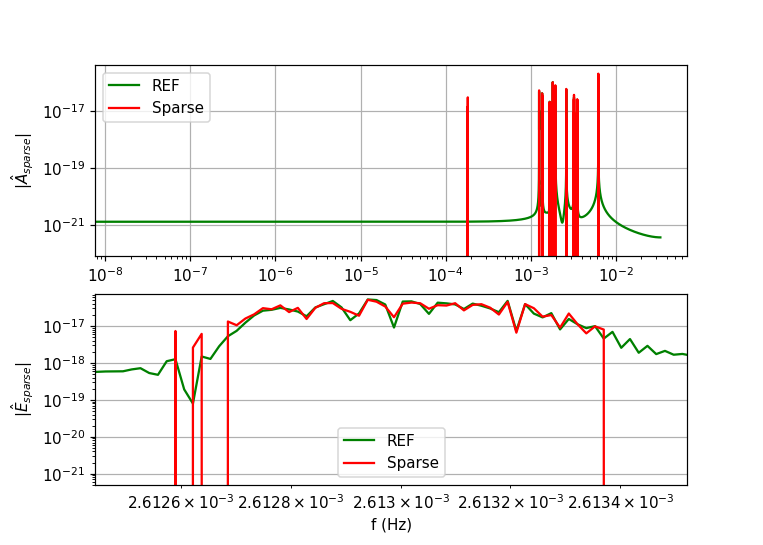

<IPython.core.display.Javascript object>


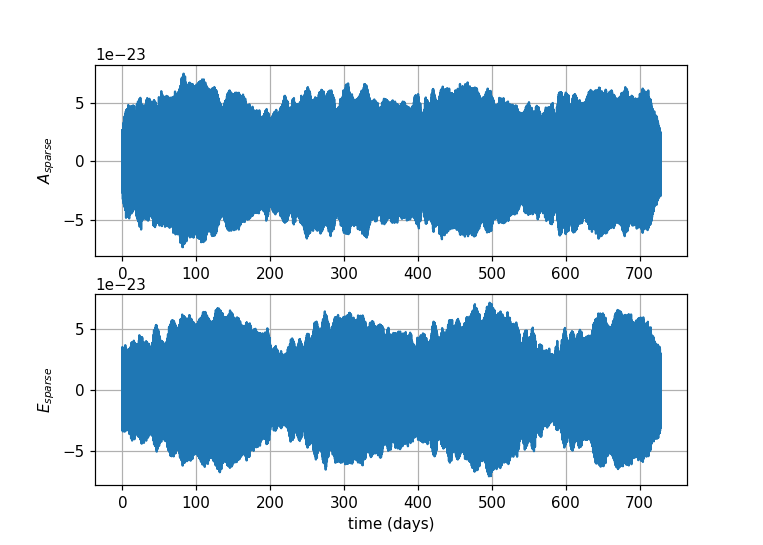

In [14]:
# solution in Fourier domain
plt.figure()
plt.subplot(2,1,1)
plt.loglog(freqD, np.abs(yf0_noNoise[:,0]),'g',label='REF')
plt.loglog(freqD, np.abs(Adf_sparse),'r',label='Sparse')
plt.ylabel(r'$|\hat{A}_{sparse}|$')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.loglog(freqD, np.abs(yf0_noNoise[:,1]),'g',label='REF')
plt.loglog(freqD, np.abs(Edf_sparse),'r',label='Sparse')
plt.ylabel(r'$|\hat{E}_{sparse}|$')
plt.grid()
plt.legend()
plt.xlabel('f (Hz)')
plt.show()

# solution in time domain
plt.figure()
plt.subplot(2,1,1)
plt.plot(tm/(86400.), At_sparse)
plt.ylabel(r'$A_{sparse}$')
plt.grid()
plt.subplot(2,1,2)
plt.plot(tm/(86400.), Et_sparse)
plt.ylabel(r'$E_{sparse}$')
plt.grid()
plt.xlabel('time (days)')
plt.show()